# Creating ROI Training Datasets from Shapefiles



This script is the most difficult to walk through, as the preliminary requirements include pre-determined training
polygons generated by the user. To generate these shapefiles, I suggest loading in the original stacked Landsat 
image into a desktop GIS client such as ArcGIS or QGIS. Ensure the three rendered colors are the proper designations
(typically Band 1 is Red/NIR, Band 2 is Blue, and Band 3 is Green, this is remote sensing 101 here...), and pan
around the image to find known areas of a specific land cover you want to classify. For the sake of both processing
time and simplicity, I have chosen 3 unique land cover classes to input into our classifier: Water, Impervious, and 
Vegetation, visible in the screenshot below:

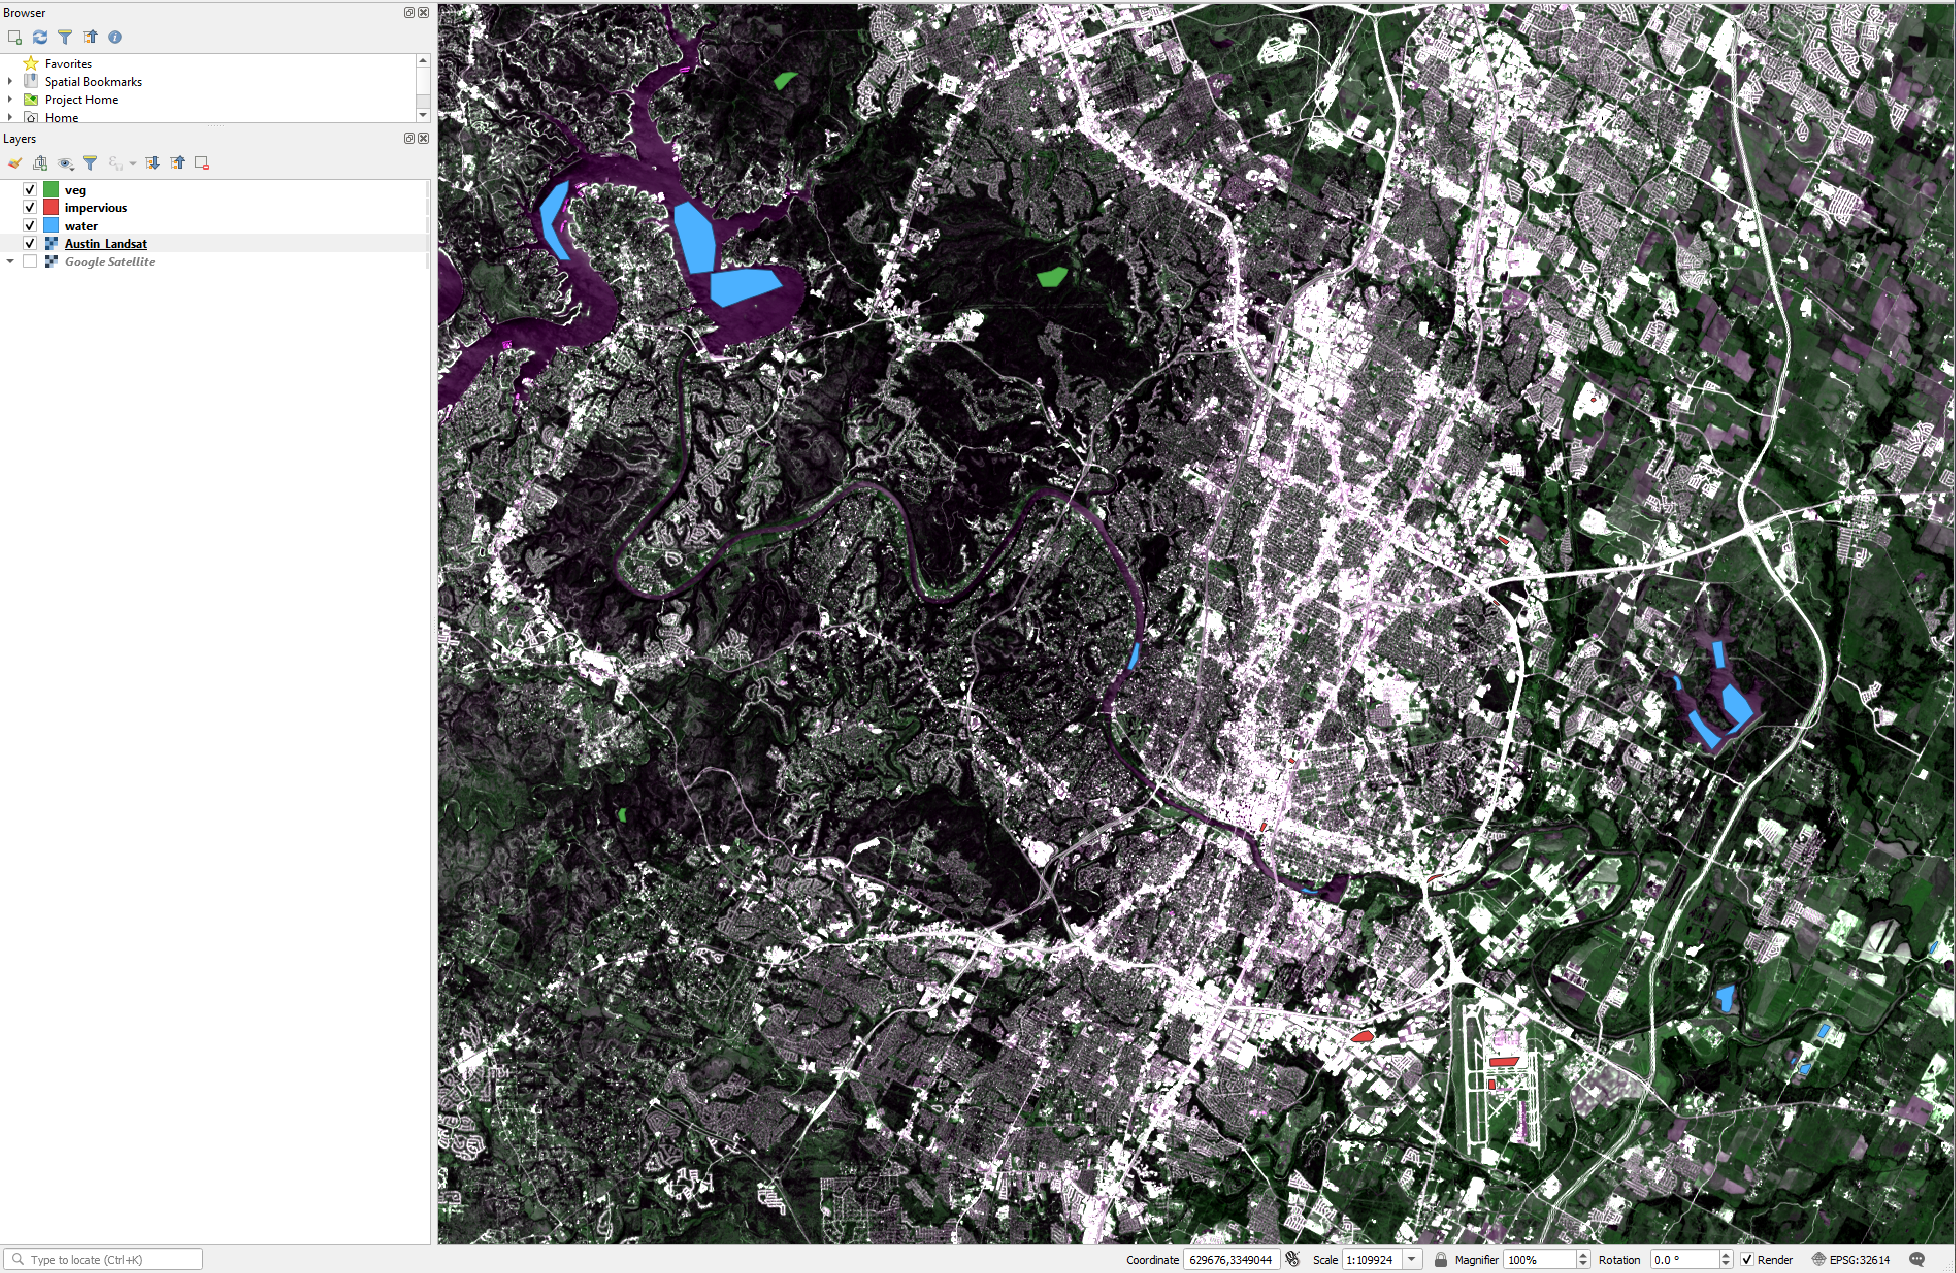

Ensure that each of your polygon features *contain pixels that are wholy representative of the cover type you want 
to classify*, as mixed training inputs may result in skewed outputs. 

This scikit-learn workflow is similar to the unsupervised KMeans, however we utilize known 'ground truths' so to speak
to train the classifier itself. In order to input these features, we must first generate an array of known labels
to input into the model. Here, we mask the input GeoTIFF image to each of the separate class polygons we generated,
then combine them into a single-band image where the values are integers corresponding to whichever class we labeled.

The inputs into this script are:
* A path to each of the classification shapefiles generated by the user
* Input GeoTIFF path of the stacked Landsat image
* Output GeoTIFF path of the training data

In [1]:
import geopandas as gpd
import gdal, ogr, osr
import numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Point, Polygon
%matplotlib inline

Input each shapefile path and add the corresponding geodataframes to a list

In [2]:
in_water = r"../../data/shapefiles/Class Shapefile Attempts/water.shp"
in_impervious = r"../../data/shapefiles/Class Shapefile Attempts/impervious.shp"
in_dense_veg = r"../../data/shapefiles/Class Shapefile Attempts/dense_veg.shp"
in_light_veg = r"../../data/shapefiles/Class Shapefile Attempts/light_veg.shp"
in_mixed = r"../../data/shapefiles/Class Shapefile Attempts/mixed.shp"

water_gdf = gpd.read_file(in_water)
imp_gdf = gpd.read_file(in_impervious)
dv_gdf = gpd.read_file(in_dense_veg)
lv_gdf = gpd.read_file(in_light_veg)
mix_gdf = gpd.read_file(in_mixed)

gdf_list = [water_gdf, imp_gdf, dv_gdf, lv_gdf, mix_gdf]

# in_tif = r"../../data/austin_clipped_landsat/Austin_Landsat_Clip_2015.tif"
in_tif = r"../../data/austin_clipped_landsat/Austin_Landsat_Clip_2020.tif"

# out_tif = r"../../data/austin_training_datasets/Austin_Training_Classes_2015.tif"
out_tif = r"../../data/austin_training_datasets/Austin_Training_Classes_2020.tif"

This loops through each of the shapefiles and extracts the corresponding Landsat 
pixel values to a same-dimensional dataset

In [3]:
out_image_list = []
with rasterio.open(in_tif) as src:
    prj = src.crs.to_wkt()
    for i in range(len(gdf_list)):
        gdf = gdf_list[i]
        gdf_reproj = gdf.to_crs(prj)
        x1, y1, x2, y2 = gdf_reproj.total_bounds
        p1 = Point(x1, y1)
        p2 = Point(x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        poly = Polygon([p1, p2, p3, p4])
        shapes = [MultiPolygon(gdf_reproj['geometry'].values)]
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=False)
        out_image[out_image != 0] = i+1
        out_image_list.append(out_image[1,:,:])
    out_meta = src.meta
    
arr = np.zeros((out_image_list[0].shape[0], out_image_list[1].shape[1]))
for out in out_image_list:
    id_int = int(out.max())
    arr[out == out.max()] = id_int

Changes the shape of the output arrays for Geotiff creation via Rasterio

In [4]:
out_write_img = arr.reshape(1, arr.shape[0], arr.shape[1])
out_write_img
out_meta.update({'count':1})

out_meta.update({"driver":"GTiff",
                "height": out_image.shape[1],
                 "width":out_image.shape[2],
                "transform": out_transform})
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_write_img)